### Task
* Given
    * Operating temp & pressure (K, atm)
    * Reaction Kinetics Information
    * Reaction Thermochemistry Information (MJ/kmol)
    * Reaction Stoichiometry
    * Composition at inlet (kmol/m3)
<br>
* To find
    * Composition at outlet (kmol/m3)
    * Cooling/Heating duty (MJ) if reactor is isothermal

#### 1.1. Using Euler's finite difference method
* 2A + B = C + 3D

In [1]:
import pandas as pd
import math

In [2]:
Univ_Gas_Const = 8.314      # kJ/kmol-K

In [3]:
stoic_cf = (-2,-1,1,3)
molecular_wt = (25,50,25,25)
sp_heat_cap = (1.1,0.8,1.5,0.9)     # kJ/kg-K
heat_of_rxn = -50000                # kJ/kmol NOTE: Exothermic reaction with no
        # cooling => Temp increase inhibits reaction.
cooling = False
cooling_duty_kJ = 0        # kJ. Initialise

arrhenius_coeff = 2
activn_energy = 200
rate_const = lambda T : arrhenius_coeff * (math.exp(-activn_energy/(Univ_Gas_Const * T)))

axial_vel = 1.2
cs_area = 1.2e-3
pfr_length = 1.1
length_step = pfr_length/10     # 10 nodes excluding endpoint
element_vol = cs_area * length_step

In [4]:
moles_A = {0.00:0.8} # Keys will be z-co-ordinate
moles_B = {0.00:0.5}
moles_C = {0.00:0}
moles_D = {0.00:0}

Temp_kelvin = {0.00:900}

if cooling is True:
    rate_const_entry = rate_const(Temp_kelvin[list(Temp_kelvin.keys())[0]])

# For 10 nodes
for i in range(10):
    z_coord = float(f"{(i*length_step):.2f}")
    z_next = float(f"{(z_coord + length_step):.2f}")
    
    # Calculate rate of reaction in this element w.r.t. A using temperature at 
    # entry of elemental volume
    if cooling is False:
        rate_A = rate_const(Temp_kelvin[z_coord]) * (moles_A[z_coord] ** abs(stoic_cf[0]))
    else:
        rate_A = rate_const_entry * (moles_A[z_coord] ** abs(stoic_cf[0]))
    
    # Calculate concentration to check for limiting reactant
    moles_reacted_A = (rate_A * (length_step ** 2)/(axial_vel))
    next_moles_A = moles_A[z_coord] - moles_reacted_A

    next_moles_B = moles_B[z_coord] - \
                    (stoic_cf[1]/stoic_cf[0]) * moles_reacted_A
    
    next_moles_C = moles_C[z_coord] - \
                    (stoic_cf[2]/stoic_cf[0]) * moles_reacted_A
    
    next_moles_D = moles_D[z_coord] - \
                    (stoic_cf[3]/stoic_cf[0]) * moles_reacted_A

    # Check for limiting reactant. Only proceed if no concentration is equal to 0
    if next_moles_A > 0 and next_moles_B > 0:
        # Calculate moles for next node
        moles_A[z_next] = next_moles_A
        moles_B[z_next] = next_moles_B
        moles_C[z_next] = next_moles_C
        moles_D[z_next] = next_moles_D

        # Calculate temperature for next node & cooling duty as per settings of reactor cooling
        if cooling is False:
            
            # Calculate density & specific heat capacity
            moles_state = [
                moles_A[z_coord],moles_B[z_coord],
                moles_C[z_coord],moles_D[z_coord]
                ]
            element_mass = sum([a*b 
                                for a,b in zip(moles_state,molecular_wt)
                                ])
            element_sp_heat_cap = sum([
                a*b*c*1e-3 
                for a,b,c in zip(moles_state,sp_heat_cap,molecular_wt)
                ])/element_vol
            
            # Calculate temperature for next node
            Temp_kelvin[z_next] = Temp_kelvin[z_coord] + (moles_reacted_A*heat_of_rxn/\
                                                      (element_mass*element_sp_heat_cap))
            
        else:
            cooling_duty_kJ += moles_reacted_A*heat_of_rxn
            Temp_kelvin[z_next] = Temp_kelvin[z_coord]
    
    # Else if some concentration is zero
    else:
        # Determine moles and temperature for next node, as being the same as current node
        moles_A[z_next] = moles_A[z_coord]
        moles_B[z_next] = moles_B[z_coord]
        moles_C[z_next] = moles_C[z_coord]
        moles_D[z_next] = moles_D[z_coord]
        Temp_kelvin[z_next] = Temp_kelvin[z_coord]
        

In [5]:
df_moles = pd.DataFrame(data=[moles_A,moles_B,moles_C,moles_D],
                       index=["moles_A","moles_B","moles_C","moles_D"]).transpose()
df_moles

,moles_A,moles_B,moles_C,moles_D
0.00,0.800000,0.500000,0.000000,0.000000
0.11,0.787434,0.493717,0.006283,0.018849
0.22,0.775259,0.487630,0.012370,0.037111
0.33,0.763458,0.481729,0.018271,0.054813
0.44,0.752014,0.476007,0.023993,0.071979
0.55,0.740910,0.470455,0.029545,0.088635
0.66,0.730131,0.465066,0.034934,0.104803
0.77,0.719664,0.459832,0.040168,0.120503
0.88,0.709495,0.454748,0.045252,0.135757
0.99,0.699612,0.449806,0.050194,0.150583


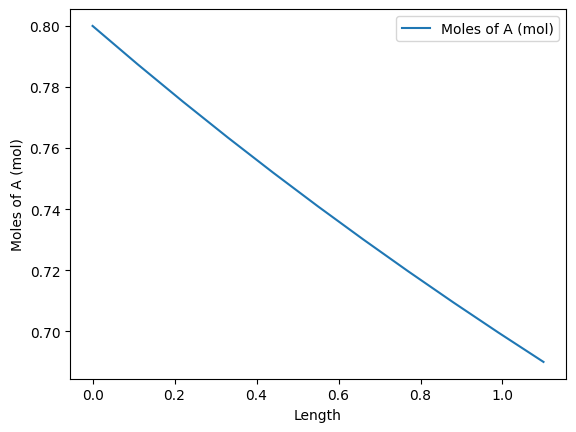

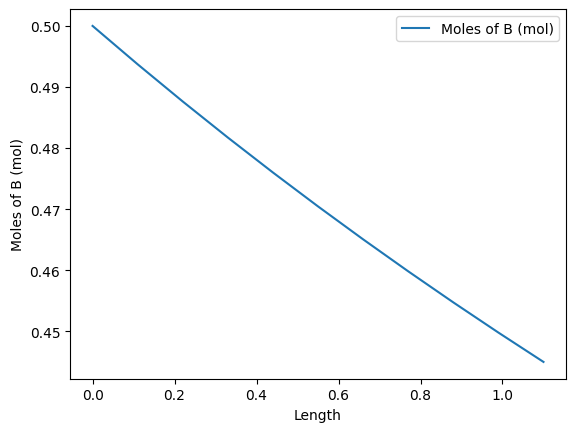

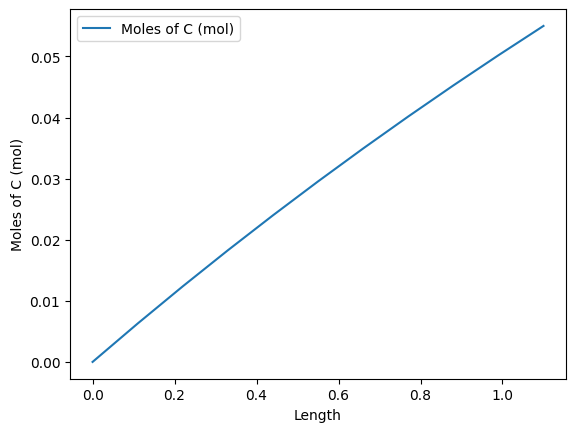

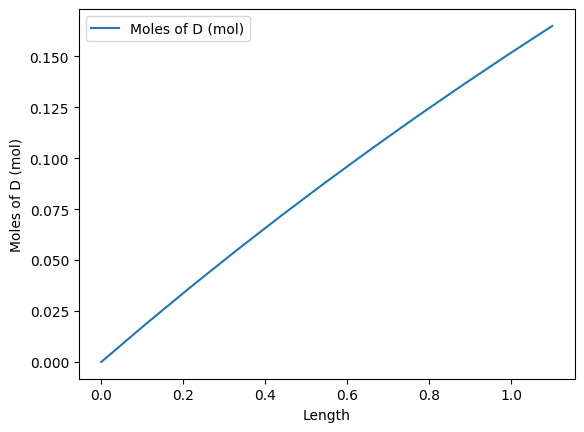

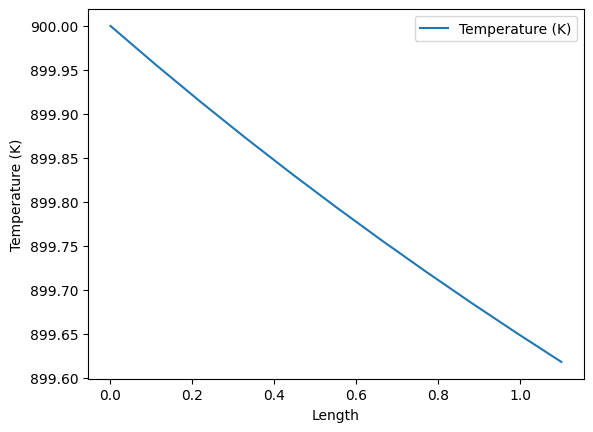

In [6]:
from matplotlib_funcs import *

plot_matplotlib_style(df_moles.index,df_moles["moles_A"],"Length","Moles of A (mol)","Moles of A (mol)")
plot_matplotlib_style(df_moles.index,df_moles["moles_B"],"Length","Moles of B (mol)","Moles of B (mol)")
plot_matplotlib_style(df_moles.index,df_moles["moles_C"],"Length","Moles of C (mol)","Moles of C (mol)")
plot_matplotlib_style(df_moles.index,df_moles["moles_D"],"Length","Moles of D (mol)","Moles of D (mol)")
plot_matplotlib_style(df_moles.index,Temp_kelvin.values(),"Length","Temperature (K)","Temperature (K)")

In [7]:
cooling_duty_kJ

0